In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy import signal
from tools import *

from sklearn.decomposition import NMF, PCA

from scipy.sparse import *
from scipy.io import mmread 

# Import auryn tools
sys.path.append(os.path.expanduser("~/auryn/tools/python/"))
from auryntools import *
from matplotlib import animation, rc
from IPython.display import HTML
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import tools
import elephant
import quantities as pq
from neo.core import SpikeTrain
import viziphant
from pyvis.network import Network
import networkx as nx
import pandas as pd

In [2]:
dure_simu = 21800
begining_presentation = 0
duree_pattern = 0.1
time_step = 0.1
auryn_tstep = 0.0001
spls = dure_simu/time_step

In [3]:
deb = 100
dur = 2
beg = int(deb//time_step)
end = beg+int(dur//time_step)

In [4]:
num_mpi_ranks = 4 # the number of sims you used in parallel
datadir = os.path.expanduser("/mnt/data1/data_paul/sim_less_stim_neurons_nocons_suite_6h_pat") # Set this to your data path
prefix = "rf1"

nb_neurons = 4096

In [5]:
#datadir_sigal = os.path.expanduser("~/data/sim_network/sim_10Hz_cons_4h_1pat_mrco_5_demonstration") # Set this to your data path
datadir_sigal = datadir

In [6]:
all_times = np.genfromtxt(datadir_sigal+'/pattern_times', delimiter=' ')
nb_pattern = len(set(all_times[:,1]))
signals = np.zeros((nb_pattern,int(dure_simu//time_step)+1))
signals_times = [[] for i in range(nb_pattern)]
for time,kind in all_times:
    signals_times[int(kind)].append(time)
    signals[int(kind),int((time)//time_step):int((time*auryn_tstep+(duree_pattern))//time_step)]=1
signals_times = np.array(signals_times)

# Find low rank structure in spiking activity

In [7]:
spkfiles  = ["%s/%s.%i.e.spk"%(datadir,prefix,i) for i in range(num_mpi_ranks)]
sfo = AurynBinarySpikeView(spkfiles)

Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)


In [8]:
#spkext = pd.read_csv("%s/%s.%i.spikes_ext.txt"%(datadir,prefix,0),delimiter=' ').values
# extfiles  = ["%s/%s.%i.ext.spk"%(datadir,prefix,i) for i in range(1)]
# sfo_ext = AurynBinarySpikeView(extfiles)

In [9]:
rateE  = np.mean([pd.read_csv("%s/%s.%i.e.prate"%(datadir,prefix,2),delimiter=' ').values for i in range(num_mpi_ranks)],axis=0)

In [10]:
time_axis = np.linspace(0,dure_simu,int(dure_simu//time_step))
rateE= rateE[:,1]

In [11]:
# plt.plot(time_axis,rateE)
# plt.plot(rateE)

In [12]:
fig = go.Figure(data=go.Scatter( y=rateE))
fig.show()

In [13]:
# plt.plot(time_axis[beg:end],rateE[beg:end])
# some_signals = signals_times[0][ (signals_times[0]<(deb+dur) ) & (signals_times[0]>deb)]
# for sig in some_signals:
#     plt.axvspan(sig, sig+duree_pattern, facecolor='red', alpha=0.25)

In [14]:
# some_signals = signals_times[0][ (signals_times[0]<(deb+dur) ) & (signals_times[0]>deb)]

In [15]:
# plt.plot(rateE[beg:end])
# plt.plot(signals[0][beg:end]*10)

In [16]:
# rateI  = np.mean([pd.read_csv("%s/%s.%i.i2.prate"%(datadir,prefix,i),delimiter=' ' ) for i in range(num_mpi_ranks)],axis=0)
# time_axis_I = rateI[:,0]
# rateI= rateI[:,1]

In [17]:
# plt.plot(time_axis_I,rateI)

In [18]:
# plt.plot(time_axis[beg:end],rateI[beg:end])
# plt.plot(time_axis[beg:end],signals[0][beg:end]*10)

In [19]:
# win = signal.windows.hann(1000)
# plt.plot(np.convolve(rateE,win)/ sum(win))

In [20]:
# win = signal.windows.hann(1000)
# plt.plot(np.convolve(rateI,win)/ sum(win))

## Raster Plot illustrant la reaction du system

In [21]:
def plot_profile(begin,end,title,nb_sample,nb_sample_ext,alpha = 1,signal = 0,more_than = 1000):

    tm_rast = begin
    time_range_rast = end
    beg_2 = int(tm_rast//time_step)
    end_2 = beg_2+int(time_range_rast//time_step)
    
    spikes_rast = np.array(sfo.get_spikes(t_start=tm_rast,t_stop=tm_rast+time_range_rast))

    ListTrains = [[] for _ in range(nb_neurons)] 
    for s in spikes_rast:
        ListTrains[int(s[1])].append(s[0])

    spikes_rast  = np.array([li for li in spikes_rast if len(ListTrains[int(li[1])])<more_than])
    np.random.seed(0)
    sample = np.random.choice(list(range(nb_neurons)),nb_sample)
    spikes_rast_sample = np.array([i for i in spikes_rast if i[1] in sample])

    spikes_rast_ext = np.array(sfo_ext.get_spikes(t_start=tm_rast,t_stop=tm_rast+time_range_rast))

    sample_ext = np.random.choice(list(range(nb_neurons)),nb_sample_ext)
    spikes_rast_sample_ext =np.array([i for i in spikes_rast_ext if i[1] in sample_ext])
    
    new_indexes = dict(zip(list(set(spikes_rast_sample[:,1])),list(range(nb_sample))))
    
    new_indexes_ext = dict(zip(list(set(spikes_rast_sample_ext[:,1])),list(range(nb_sample_ext))))
    
    colors = in_pattern(spikes_rast_sample_ext,duree_pattern, signals_times[0])
    colors = ["r" if i ==1 else "b" for i in colors]
    
    fig, axs = plt.subplots(3,figsize=(8,10),sharex=True,gridspec_kw={'height_ratios': [2,2, 1]})
    fig.suptitle(title,y = 0.92,fontsize = 15)
    
    axs[0].scatter(spikes_rast_sample_ext[:,0], 
                   [new_indexes_ext[i] for i in spikes_rast_sample_ext[:,1]],alpha = alpha, c =colors,s = 18)
    axs[0].set_ylabel("input neuron index",fontsize = 12)

    axs[1].scatter(spikes_rast_sample[:,0], 
                   [new_indexes[i] for i in spikes_rast_sample[:,1]],alpha = alpha, c="b",s = 18)
    axs[1].set_ylabel("output neuron index",fontsize = 12)

    some_signals = signals_times[0][ (signals_times[0]<(tm_rast+time_range_rast) ) & (signals_times[0]>tm_rast)]

    axs[2].plot(time_axis[beg_2:end_2],rateE[beg_2:end_2])

    for sig in some_signals:
        axs[2].axvspan(sig, sig+duree_pattern, facecolor='red', alpha=0.25)
    
    axs[2].set_ylabel("rate (Hz)",fontsize = 12)
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Time (s)",fontsize = 12)
    #plt.ylabel("common Y",x = 0)
    

In [22]:
# plot_profile(110.4,1.1,"Before learning",1500,150,more_than = 20)

In [23]:
# plot_profile(14385,1.1,"After learning",1500,150,more_than = 20)

In [24]:
tm = 21500
time_range = 200 # it was 200
which_signal = 0

In [25]:
spikes = np.array(sfo.get_spikes(t_start=tm,t_stop=tm+time_range))

In [26]:
#spikes_all = np.array(sfo.get_spikes())

In [27]:
#np.savetxt("%s/e_spikes.txt"%(datadir),spikes_all)

In [28]:
times,dists = tools.SpikesDistFromPat(spikes[:,0],duree_pattern,signals_times[which_signal])

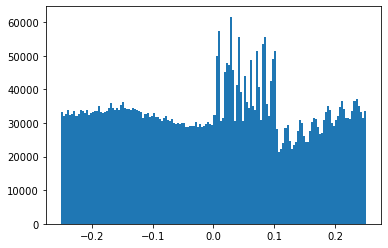

In [29]:
plt.hist(dists,bins=150);

In [30]:
#px.histogram(dists)

In [32]:
ListTrains = [[] for _ in range(nb_neurons)] 
for s in spikes:
    ListTrains[int(s[1])].append(s[0])

In [36]:
distancesN = SpikesDistNeurones(spikes,duree_pattern,signals_times[which_signal],window = 0.2,offset=0.05)

In [37]:
scores = np.array([ np.sum(np.logical_and(np.array(x)[:,0]<duree_pattern,np.array(x)[:,0]>0))/len(x) for x in distancesN if len(x)>0])

### Certains neurones sont hyper actifs.

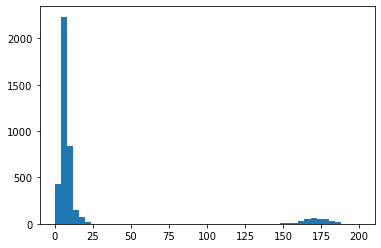

In [307]:
plt.hist(list(map(len,ListTrains)),bins=50);

### Une minorité code bien le signal

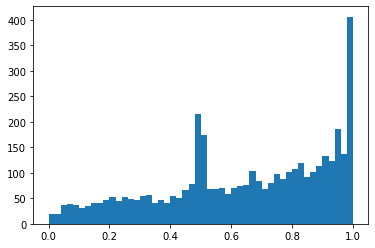

In [38]:
plt.hist(scores,bins=50);

In [309]:
not_to_fast_ones  = [ListTrains[li]  for li in range(len(ListTrains)) if len(ListTrains[li])<1000]

### Un neuron parfait ?

In [39]:
the_one = np.argmax(scores)

### Et qui fire assez souvent. Si sont firing rate était à la ramasse, on aurait pu penser 
### qu'il se serait fait attribué un bon score par accident.

In [40]:
distTrainOne = np.array(distancesN[the_one])

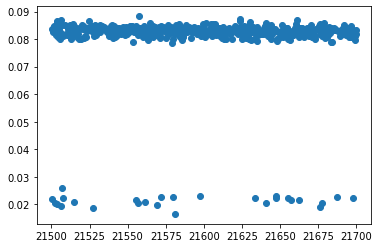

In [41]:
plt.scatter(distTrainOne[:,1],distTrainOne[:,0])

### Des bons neurones 

In [313]:
ratio = 0.01

In [314]:
the_ones = scores.argsort()[-int((len(scores)*ratio)):][::-1]

In [315]:
the_ones

array([   0, 1613, 3764, 2851, 1664, 3768, 1663, 2862, 1653, 2876, 1617,
       1610, 1273, 2896, 2921, 3779, 1578, 3782, 1574, 1572, 1565, 3786,
       1695, 1696, 1702, 2848, 1917, 1904, 2812, 1881, 1870, 2815, 2823,
       1848, 1847, 1833, 1831, 1817, 1811, 3750])

In [316]:
scatter_ones = np.sort([spike  for  n in the_ones for spike in ListTrains[n]])

In [317]:
times_ones ,dists_ones = tools.SpikesDistFromPat(scatter_ones,duree_pattern,signals_times[which_signal],window=0.2)

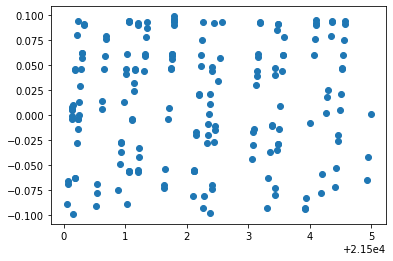

In [318]:
plt.scatter(times_ones,dists_ones)

In [319]:
ListTrainsNeoTheOnes = []
min1 = 1000000000
max1 = 0
for train in the_ones:
    min2=min(ListTrains[train])
    max2=max(ListTrains[train])
    if min2 < min1:
        min1=min2 
    if max2 > max1:
        max1=max2 

for train in the_ones:
 ListTrainsNeoTheOnes.append(SpikeTrain(ListTrains[train]*pq.s,t_start=min1,t_stop=max1))

In [320]:
result_spade = elephant.spade.spade(ListTrainsNeoTheOnes, 10*pq.ms, 10)

Time for data mining: 0.024285078048706055


In [324]:
viziphant.patterns.plot_patterns?

Object `viziphant.patterns.plot_patterns` not found.


In [321]:
viziphant.patterns.plot_patterns(ListTrainsNeoTheOnes)

AttributeError: module 'viziphant' has no attribute 'patterns'

In [49]:
# trains = []
# for i in the_ones:
#     trains.append(ListTrains[i])
# trains = np.sort(np.array([j for i in trains for j in i]))
# lelu = SpikeTrain(trains*pq.s,t_start=min(trains),t_stop=max(trains))
# signi_train =elephant.statistics.instantaneous_rate(lelu,1*pq.ms)

In [50]:
# plt.plot(signi_train.times,signi_train/len(the_ones))

# Load and analyze EE weights

In [51]:
wmatfiles  = ["%s/rf1.%i.ee.wmat"%(datadir,i) for i in range(num_mpi_ranks)]
w = np.sum( [ mmread(wf) for wf in wmatfiles ] )

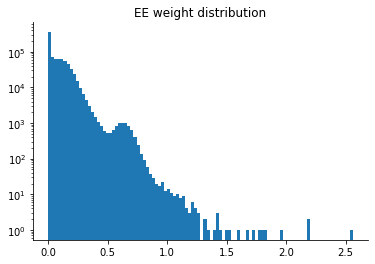

In [52]:
h1 = plt.hist(w.data, bins=100, log=True)
plt.title("EE weight distribution")
sns.despine()

In [117]:
net = Network(notebook=True)
mean_weight = np.mean(w.data)

In [118]:
for n in the_ones:
    net.add_node(int(n))

In [119]:
connectivity_pat =[]
bon_poids=[]
for n in the_ones:
    for n2 in the_ones:
        if w[n,n2]>0:
            if w[n,n2]>mean_weight:
                bon_poids.append(w[n,n2])
                net.add_edge(int(n), int(n2), weight=float(w[n,n2]))
            connectivity_pat.append([n,n2,w[n,n2]])
connectivity_pat = np.array(connectivity_pat)        

In [120]:
print("Mean inhibitory weight of "+str(np.mean(connectivity_pat[:,2]))+" for coding neurons vs "+str(mean_weight)+" for all neurons")

Mean inhibitory weight of 0.2579561116351093 for coding neurons vs 0.08064553000966523 for all neurons


In [121]:
the_ones

array([1262, 2768, 3808, 2734,  441, 3083, 1208, 2960, 2695, 2759, 3318,
        442, 1543, 1425, 3225, 2236, 3349, 2506, 1802, 3848, 3568, 1203,
       2144, 1690,  176, 2349, 2479, 1008, 3993, 3902, 3720,  854,  960,
       2352, 3176, 3217, 3739, 1809,  268, 2774, 2255, 3281,  277,   43,
       3894, 3214,  610,  672, 2576, 2388,  266, 2555, 3389, 1968, 4070,
       2661, 1429, 1260, 4028, 3630, 2805, 1712, 3334, 1583, 1364,  911,
       1828, 3876, 2795, 2438,  125,  698,  732, 2430, 1027, 2518, 2785,
        132, 3404, 2121,  997])

In [122]:
#net.show("mynet.html")

In [123]:
# def max_path(net):
#     paths = [[] for i in range(len(nodes))]
#     in_paths = [set() for i in range(len(nodes))]
#     traited = []
#     for n in nodes:
#         still_nodes = True
#         while still_nodes:
#             possible_nodes = linked_nodes-in_paths[n]
#             if len(possible_nodes)>0:
#                 next_node=max(possible_nodes)
#                 paths[n].append(next_node)
#                 in_paths[n].add(next_node)
#             else:
#                 still_nodes = False
#         traited.append(n)


In [134]:
net_dic = net.get_adj_list()

In [135]:
nodes = set(net_dic.keys())

In [170]:
paths = {i:[i] for i in nodes}
in_paths = {i:set([i]) for i in nodes}
traited = []

for n in nodes:
    still_nodes = True
    while still_nodes:
        possible_nodes = list(net_dic[n]-in_paths[n])
        if len(possible_nodes)>0:
            next_node = possible_nodes[np.argmax([w[n,pn] for pn in possible_nodes])]
            #print([w[n,pn] for pn in possible_nodes])
            if next_node in traited and  w[paths[n][-1],next_node] > mean_weight:
                paths[n] = paths[n]+paths[next_node]
                in_paths[n]=in_paths[n].union(in_paths[next_node])
            elif w[paths[n][-1],next_node] > mean_weight :
                paths[n].append(next_node)
                in_paths[n].add(next_node)
                still_nodes= False
            else:
                still_nodes= False
        else:
            still_nodes = False
    traited.append(n)

In [171]:
#  taille = 0
#  for i in paths:
#      if len(paths[i])>taille:
#          taille = len(paths[i])
#          largest_path = paths[i]

In [192]:
strength = 0
for i in paths :
    chemin =paths[i]
    strength2 = np.sum([w[chemin[i],chemin[i+1]] for i in range(len(chemin)-1)])
    if strength2 > strength:
        strength = strength
        strongest_path = i
strongest_path = paths[strongest_path]

In [193]:
strongest_path

[2555, 1690, 2506]

In [195]:
weights = []
for n in range(len(strongest_path)-1):
    weights.append(w[strongest_path[n],strongest_path[n+1]])

In [196]:
weights

[0.4008148, 0.77853215]

### Des neurones très connectés avec une activité liée dans le temps 

In [197]:
distTrainPost = np.array(distancesN[int(strongest_path[0])])
distTrainPre = np.array(distancesN[int(strongest_path[1])])
distTrainPre2 = np.array(distancesN[int(strongest_path[2])])

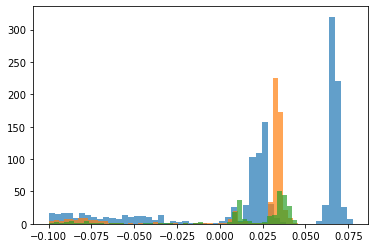

In [201]:
plt.hist(distTrainPost[:,0],bins=50,alpha = 0.7);
plt.hist(distTrainPre[:,0],bins=50,alpha = 0.7);
plt.hist(distTrainPre2[:,0],bins=50,alpha = 0.7);

In [669]:
most_connected_arg = connectivity_pat[connectivity_pat[:,2].argsort()[-50:][::-1]]
most_connected= most_connected_arg[:,[0,1]].ravel().astype(int)
scores_mst =scores[most_connected]

In [670]:
net = Network(notebook=True)
net.add_nodes(most_connected)
net.add_edges(most_connected_arg)


In [703]:
#net.show("my_network.html")